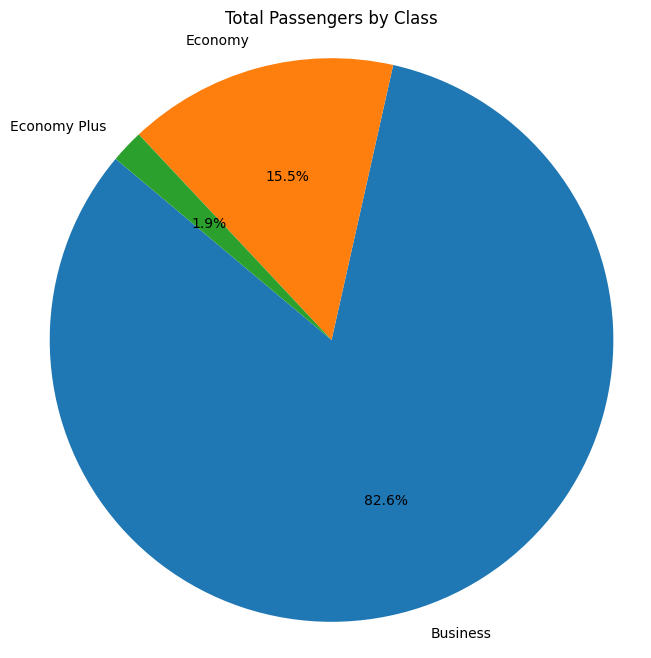

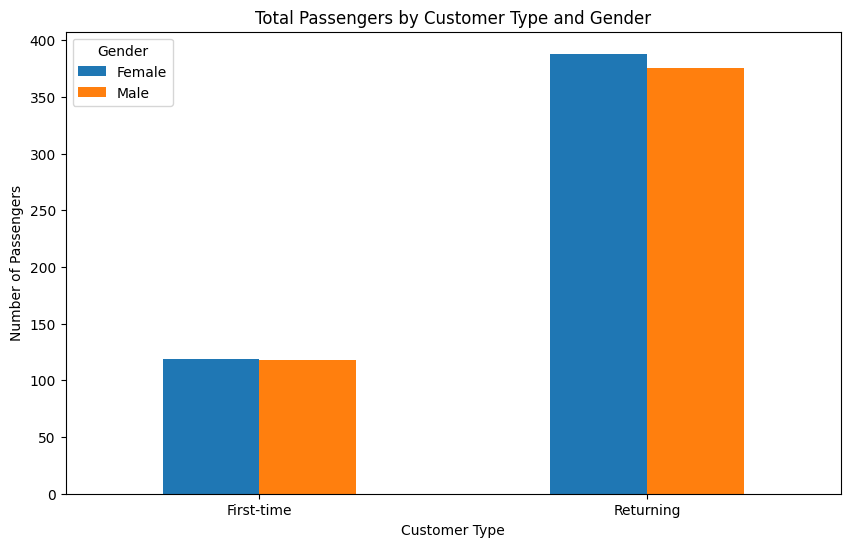

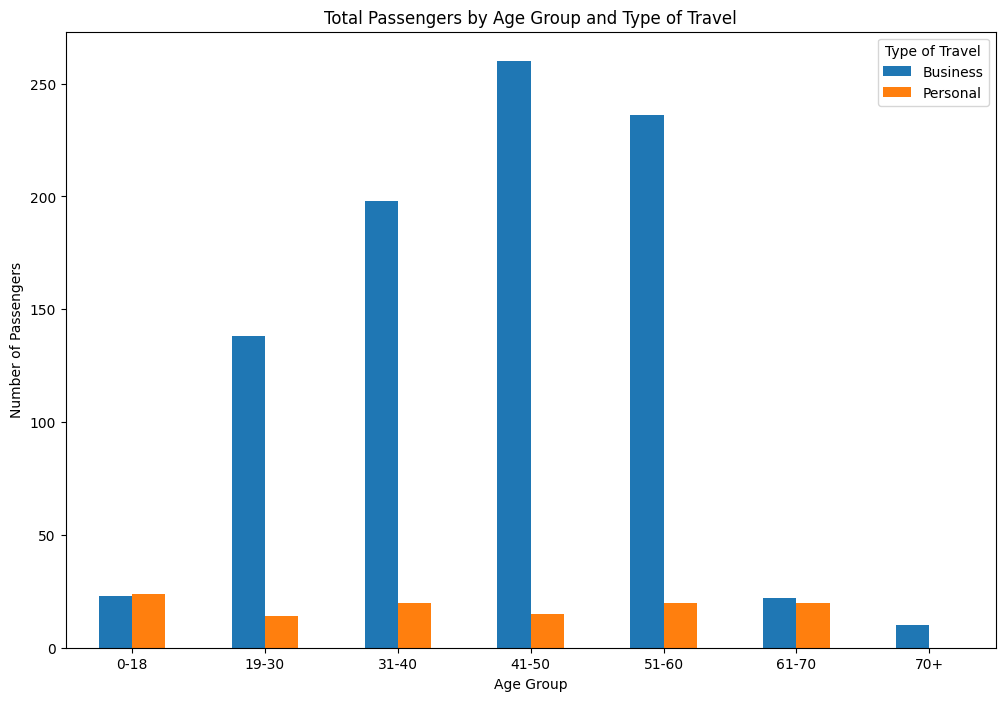

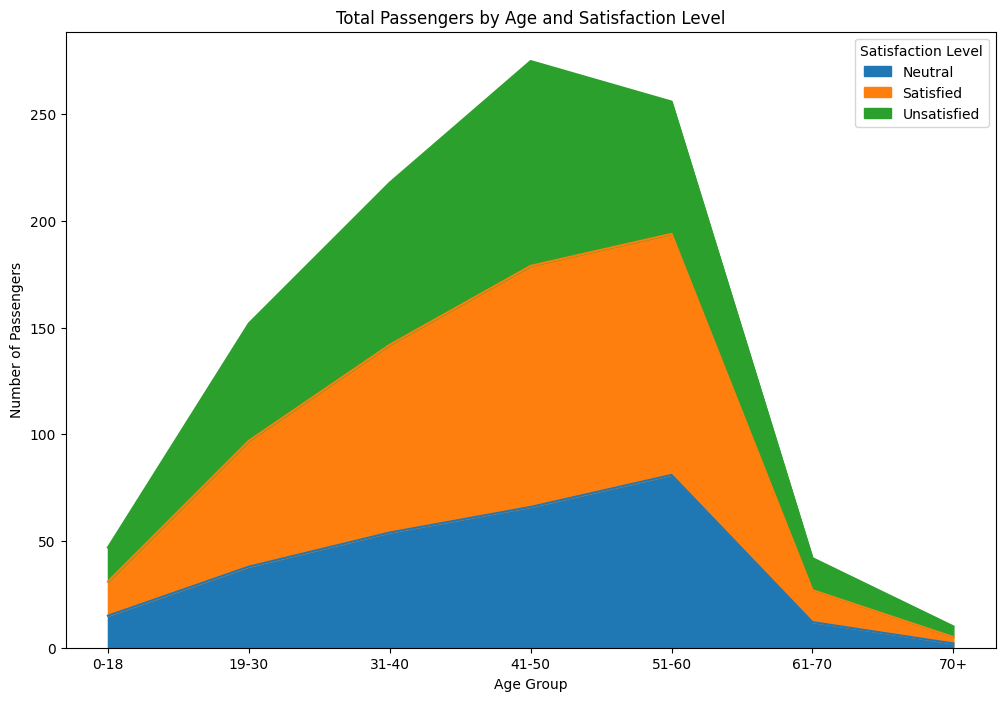

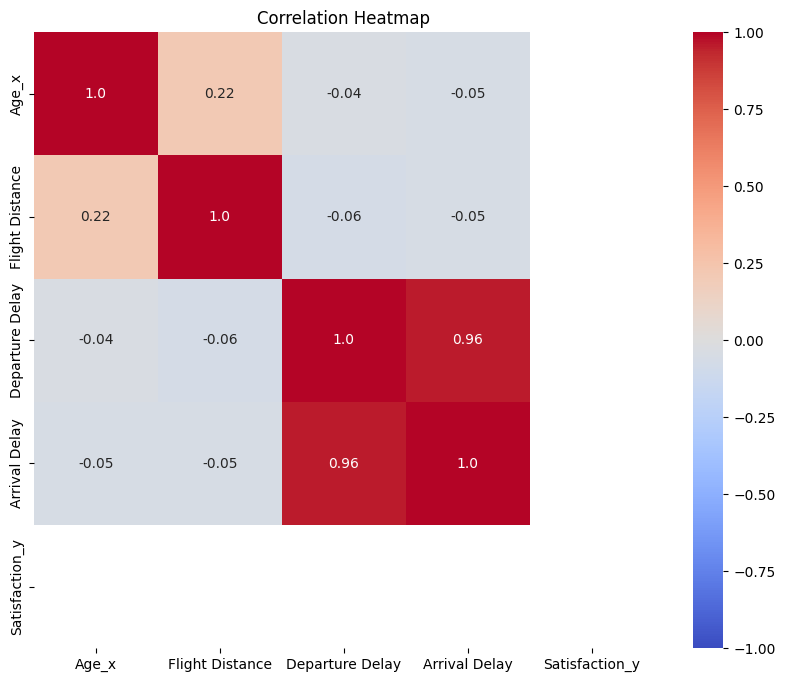

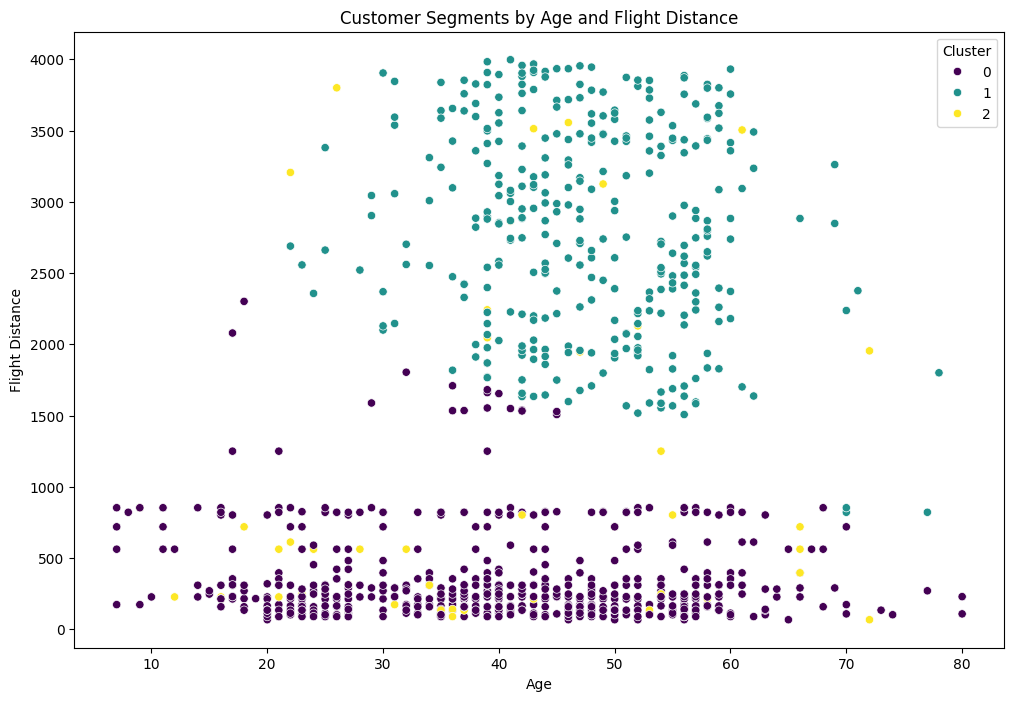

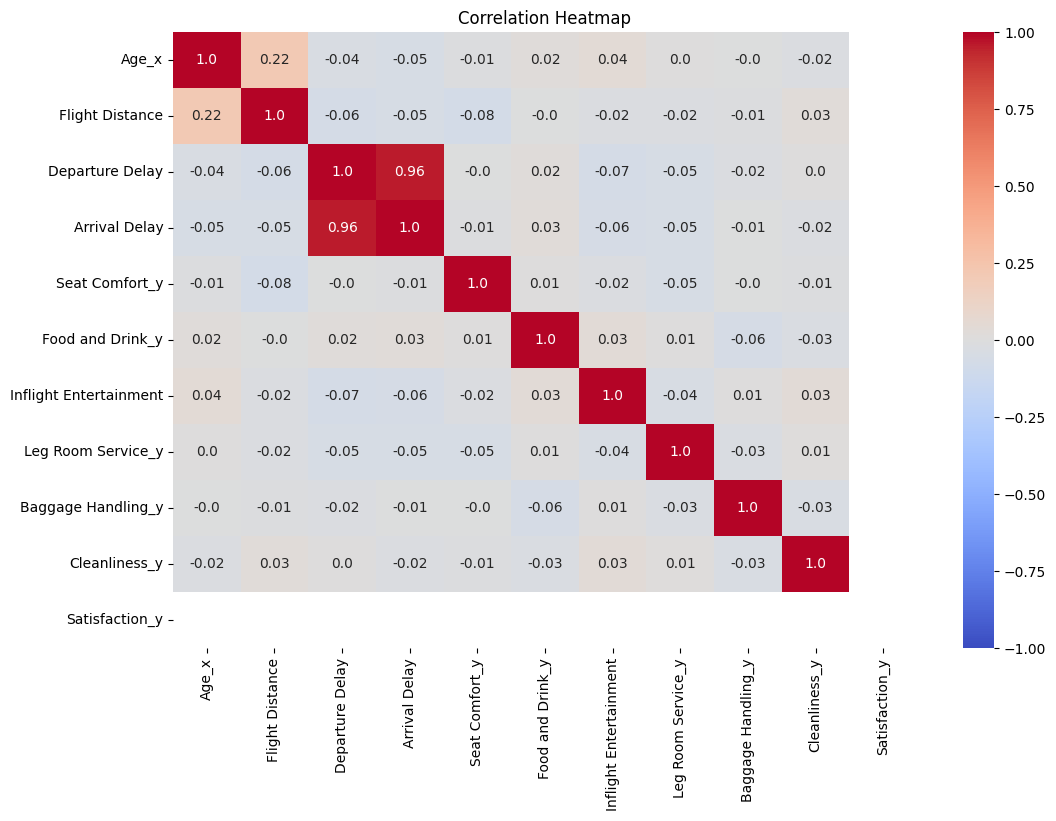

In [3]:
# Begin by importing the following packages needed:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import sqlite3

#Let's establish connection to database:
conn = sqlite3.connect('airline_insights.db')
cursor = conn.cursor()

# Load the dataset:
data = pd.read_csv('merged_data.csv')

# Segmenting Passengers for Key Insights
# We will start segmenting our passengers to visualize and identify key segments of the passengers based on their class, customer type, gender, age, and overall satisfaction levels.

# Key Questions: 
# Which aspects of the travel experience most influence overall satisfaction?
# Are there any specific areas where improvement could significantly enhance passenger satisfaction?
# How do the different classes (Business, Economy, Economy Plus) rate various aspects of their travel experience?

# Visualization 1: Pie Chart of Total Passengers by Class
class_distribution = data['Class'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Passengers by Class')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

# So what were the insights from Passenger Class Distribution: Business Class has the highest percentage of passengers. This will later help in understanding the preferences of the majority of travelers and tailoring services and marketing strategies to cater to their needs.


# Analyzing Passenger Distribution Customer Type & Gender

# Key Questions:
# What is the distribution of passengers by customer type & gender?
# Are there more returning or first-time customers?
# Is there a significant difference in gender distribution among passengers?

# Visualization 2: Bar Chart of Total Passengers by Customer Type and Gender
customer_gender_distribution = data.groupby(['Customer Type', 'Gender_x']).size().unstack()

customer_gender_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Total Passengers by Customer Type and Gender')
plt.xlabel('Customer Type')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.show()

# Great! This chart shows a significant difference in the number of returning customers, with a slightly higher proportion of female passengers. This suggests an opportunity for targeted loyalty programs. For first-time passengers, females also rank slightly higher than males, indicating that initial engagement strategies might be tailored to attract and convert female first-time passengers into loyal customers.


# Analyzing Age Group Distribution across reasons of travel. We are visually using a bar chart to give a clear side by side comparision across different age groups.

# Key Questions:
# Which age group travels the most for business vs personal?

# Create age groups
bins = [0, 18, 30, 40, 50, 60, 70, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '70+']
data['Age Group'] = pd.cut(data['Age_x'], bins=bins, labels=labels)

# Visualization 3: Grouped Bar Chart of Total Passengers by Age Group and Type of Travel
age_travel_distribution = data.groupby(['Age Group', 'Type of Travel'], observed=False).size().unstack()

age_travel_distribution.plot(kind='bar', figsize=(12, 8))
plt.title('Total Passengers by Age Group and Type of Travel')
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')
plt.legend(title='Type of Travel')
plt.xticks(rotation=0)
plt.show()

# Okay this helps us further identify the travel purposes for each age group. This is what we know:
# Age Group 19- 30 and 31- 50 are the primary segments for business travel
# Age Group 51-60 shows a balance of interest in both travel and personal
# Age Group 0-18 and 70+ have minimal travel activity

# So what does this tell us? 
# Age Group 19-30 and 31-50 are the main business travelers, indicating a strong need for business related services. 
# Age Group 51- 60 are a mix, so are probably more verstatile in their preferred service offerings
# Age Group 0-18 and 70+ are not a primary target for business purposes.

# Our next visualization will be focused on passenger satisfaction across age. By using a stacked area chart, we will be able to identify how the satisfaction levels change with age.

# Key Questions:
# How does passenger satisfaction vary across different age groups?
# Which age group has the highest level of satisfaction or dissatisfaction?

# Visualization 4: Stacked Area Chart of Total Passengers by Age and Satisfaction Level
age_satisfaction_distribution = data.groupby(['Age Group', 'Satisfaction_y'], observed=False).size().unstack()

age_satisfaction_distribution.plot(kind='area', figsize=(12, 8), stacked=True)
plt.title('Total Passengers by Age and Satisfaction Level')
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')
plt.legend(title='Satisfaction Level')
plt.xticks(rotation=0)
plt.show()

#So let's unpack & combine this with what we alreay know:
# Age Group 19-30:
# Shows significant dissatisfaction though moderate level of satisfaction
# Primary travelers for business
# Despite being a major business traveler segment, the high levels of dissatisfaction indicate a major need for targeted imrpovement.
# Efforts should focus on this segment's needs and pain points.

# Age Group 31- 60: 
# Shows high level of satisfaction, suggesting current needs are being met.
# Predominataly travels for business
# This group is a key demographic traveler segment, and should remain a continued focus to maintain satisfaction levels.

# Age Group 0-18 and 70+ :
# Shows minimal travel & engagment acitivy
# Not a primary traveler segment


# Next we are going to utilize a heatmap to help us visualize the correlation between different variables.
# Key Questions:
# How do various factors like age, flight distance, and delays correlate with passenger satisfaction?
# Which factors are most strongly correlated with eachother and what implications do these correlations provide?

# Visualization 5: Heatmap

# Load the dataset
data = pd.read_csv('merged_data.csv')

# Select relevant columns for the heatmap
heatmap_data = data[['Age_x', 'Flight Distance', 'Departure Delay', 'Arrival Delay', 'Satisfaction_y']].copy()

# Convert satisfaction to numeric for correlation
satisfaction_mapping = {'Neutral or Dissatisfied': 0, 'Satisfied': 1}
heatmap_data.loc[:, 'Satisfaction_y'] = heatmap_data['Satisfaction_y'].map(satisfaction_mapping)

# Calculate correlation matrix
correlation_matrix = heatmap_data.corr()

# Format annotations
formatted_corr = correlation_matrix.round(2).astype(str)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=formatted_corr, cmap='coolwarm', vmin=-1, vmax=1, fmt="")
plt.title('Correlation Heatmap')
plt.show()

#Let's analyze:
# Age & Flight Distance show a slight positive correlation (.22), indicating that older passengers might tend to travel longer distances. 
# Departure Delay & Arrival Delay show a very high correlation (.96), indicating that delays are consistent throughout the travel experience. As well, that delays have a small but negative impact on satisfaction.

# Visualzation 6: Customer Clustering

# By utilizing a clustering visual, this will help identify distinct patterns of customers based on their characteristics (age & flight distance).

# Key Questions:
# What are the distinct customer segments based on age and flight distance?
# How do these segments differ in terms of travel behavior and preferences?
# What insights can we gain about the needs and preferences of each cluster to tailor our services accordingly?

# Load the dataset
data = pd.read_csv('merged_data.csv')

# Select relevant columns for clustering
clustering_data = data[['Age_x', 'Flight Distance', 'Departure Delay', 'Arrival Delay']]

# Fill missing values with mean
clustering_data = clustering_data.fillna(clustering_data.mean())

# Standardize the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Perform K-means clustering with n_init set explicitly
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Age_x', y='Flight Distance', hue='Cluster', data=data, palette='viridis')
plt.title('Customer Segments by Age and Flight Distance')
plt.xlabel('Age')
plt.ylabel('Flight Distance')
plt.show()

# Okay! To break this down:
# Cluster 0 is primarily younger passengers taking shorter, more frequent trips (0-1000 miles). This group indicates they might favor convenience and efficiency.
# Cluster 1 is a mix of various ages taking medium to long flights (1000-4000 miles). This segment likely represents more experienced travelers, probably our business travelers. Indicating comfort and premium services would cater well to this group.
# Cluster 2 is a mix of varrious ages going a moderate flight distance (0-2000 miles). This group probably includes your occasional travelers, indicating a balanced mix of preferred services.

# In conclusion, to enhance customer satisfaction & loyalty, airlines should:

# Develop engagement strategies that are inclusive, focusing on both male and female first-time travelers. Loyalty programs could be more effective if tailored to the preferences of returning female passengers.
# Prioritize reducing delays, but the focus should be on enhancing overall service quality, amenities, and customer service.
# Improve efficiency and convenience for younger, frequent travelers.
# Enhance comfort and premium services for older, long- haul travlers.
# Maintain versatile service offerings for the 51-60 age group.
# Focus on business related amenties and service quality for 19-50 age group.


# Let's move into our Product Insights..


# Feature Correlation Analysis  
# Load the dataset
data = pd.read_csv('merged_data.csv')

# Select relevant features and the target variable (Satisfaction)
features = ['Age_x', 'Flight Distance', 'Departure Delay', 'Arrival Delay',
            'Seat Comfort_y', 'Food and Drink_y', 'Inflight Entertainment',
            'Leg Room Service_y', 'Baggage Handling_y', 'Cleanliness_y']
target = 'Satisfaction_y'

# Convert satisfaction to numeric for analysis
satisfaction_mapping = {'Neutral or Dissatisfied': 0, 'Satisfied': 1}
data[target] = data[target].map(satisfaction_mapping)

# Calculate the correlation matrix
correlation_matrix = data[features + [target]].corr()

# Format annotations for the heatmap
formatted_corr = correlation_matrix.round(2).astype(str)

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=formatted_corr, cmap='coolwarm', vmin=-1, vmax=1, fmt="")
plt.title('Correlation Heatmap')
plt.show()
